In [1]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

##  第31章 均線系統策略

從事投資的朋友大概都不會反對「趨勢是我們的朋友」這句話。趨勢交易策略長期以來被認為具有良好的獲利能力，因此，交易員常圍著它思考兩個問題：如何判斷趨勢，及如何利用它進行交易。捕捉趨勢最普遍的方法為移動平均線，根據求平均的方式不同，可以有簡單移動平均數（Simple Moving Average，SMA）、加權移動平均數（Weighted Moving Average，WMA）和指數移動平均數（Exponential Moving Average，EXPMA 或 EMA）

### 31.1 簡單移動平均

#### 31.1.1 簡單移動平均數

回顧一下求解算術平均數的方法，即先對一組數據的值求和，再用這個總和除以這組數據的個數來得到算術平均數。同理，股價的簡單移動平均數就是將一組股價值相加，再除以股價的個數。因此，需先確定對哪幾個數求平均數，即確定股價的個數。一般來說，我們以日、周為單位，比如求 5 日的平均數，10 日的平均數，20 日的平均數或者求 3 周的平均數。此外，還請注意，為了體現「移動」兩字的作用，在求得第一個平均數以後，若要求第二個平均數，就要把原來的一組數的最早一項股價減去，再加上新的一項股價，求和後再除以股價的個數，以得到第二個平均數。

根據定義，股票在第 1 日到 4 日無法求出 5 日價格簡單移動平均數。第 5 天的簡單平均數為

$$\mbox{SMA}_{t=5}=\frac{p_1+p_2+p_3+p_4+p_5}{5}$$

其中 $p_1,p_2,p_3,p_4,p_5$ 分別表示股票第 1 天、第 2 天、第 3 天、第 4 天、第 5 天的價格。第 6 天的 5 日簡單移動平均數則為

$$\mbox{SMA}_{t=6}=\frac{p_2+p_3+p_4+p_5+p_6}{5}$$

即去掉第一天的價格，加上第 6 天的價格 $p_6$，然後除以 5。同理，計算出第 7 天及之後的簡單移動平均數，再用這些數據繪製時間序列圖，就可得到股價的簡單移動平均曲線。首先，讀取台積電 2014 年以來的交易數據，提取收盤價，並繪製收盤價時序圖。

In [2]:
# 獲取台積電交易數據
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False
TSMC=pd.read_csv('.\\PythonBook_code_data\\part5\\31\\2330.csv',sep='\t')
TSMC.index=pd.to_datetime(TSMC.Date)
TSMC.head(n=3)

,Date,Close,Open,High,Low,Volume
Date,,,,,,
2015-01-05,2015-01-05,130.10,131.03,131.03,128.23,32214
2015-01-06,2015-01-06,124.50,128.23,128.23,124.04,67649
2015-01-07,2015-01-07,124.97,124.50,125.90,124.50,43886


D:\myProgram\Portable Python 3.6.5 x64 R2\App\Python\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Date')

Text(0, 0.5, 'Close')

Text(0.5, 1.0, '台積電股票收盤價時序圖')

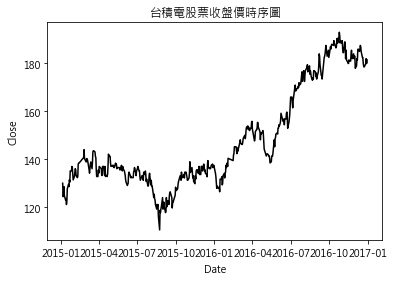

In [3]:
# 提取收盤價數據
Close=TSMC.Close
# 繪製收盤價數據時序圖
plt.plot(Close,'k')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('台積電股票收盤價時序圖')

圖 31.1：台積電股票收盤價時序圖

接下來，用 Python 撰寫程式碼示範台積電收盤價的 5 日簡單移動平均數的求值過程。

Date
2016-12-26    179.9
2016-12-27    179.4
2016-12-28    179.8
2016-12-29    180.0
2016-12-30    180.6
dtype: float64

Text(0.5, 1.0, '台積電收盤價與簡單移動平均線圖')

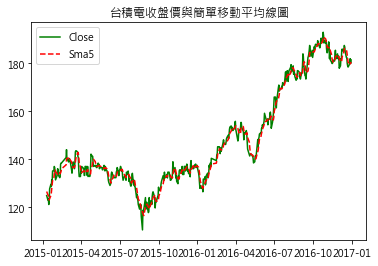

In [4]:
Sma5=pd.Series(0.0,index=Close.index)
for i in range(4,len(Close)):
    Sma5[i]=np.mean(Close[(i-4):(i+1)])
Sma5.tail()
# 繪製收盤價與簡單移動平均線的曲線圖
plt.plot(Close[4:],label="Close",color='g')
plt.plot(Sma5[4:],label="Sma5",color='r',linestyle='dashed')
plt.title("台積電收盤價與簡單移動平均線圖")
plt.legend()

圖 31.2：台積電5日簡單移動平均線

#### 31.1.2 簡單移動平均函數

前面講述了 5 日簡單移動平均線的求值過程，為了計算任一期數的簡單移動平均線，我們可以用 Python 撰寫一個計算 $k$ 期簡單移動平均函數 smaCal()。具體程式碼如下：

In [5]:
def smaCal(tsPrice,k):
    sma=pd.Series([np.nan]*len(tsPrice),index=tsPrice.index)
    for i in range(k-1,len(tsPrice)):
        sma[i]=np.mean(tsPrice[(i-k+1):(i+1)])
    return(sma)

運用 smaCal() 函數計算簡單移動平均價格。

smaCal() 事先建立一個 Series 用於存簡單移動平均值，我們還可以運用產生器的方式來計算簡單移動平均值。與建立 Series 相比，產生器的使用相對節省記憶體空間。

In [6]:
def smaCal_gene(price,k):
# priceList 只存需要計算的 k 期股價數據
    priceList=[]
    n = len(price)
    for i in range(n):
    # 在 priceList 中増加最新一筆數據
        priceList.append(price[i])
        if len(priceList)==k:
            yield np.mean(priceList)
        # 刪除priceList中第0期數據
            priceList.pop(0)

# 產生一個5日簡單移動平均價的產生器
sma5_generator = smaCal_gene(Close,5)

# 運用next()獲取簡單移動平均值
next(sma5_generator)

126.648

In [7]:
next(sma5_generator)

125.248

#### 31.1.3 期數選擇

移動平均的期數的選擇對簡單移動平均的修匀效果影響很大，要確定移動平均的期數，一般需要從以下三個方面考慮：

1. 事件發展的週期性。如果事件的發展具有週期性，一般應以週期長度作為移動平均的間隔長度。比如研究每年的平均氣溫變化趨勢，對其做 12 期移動平均，以便消除季節效應的影響。

2. 對趨勢平均性的要求。一般來說，移動平均的期數越多，修勻效果越平均，表現出的趨勢就越清晰。

3. 對趨勢反映近期變化敏感程度的要求。用移動平均方法確定事件的發展趨勢都具有一定的滯後陸。移動平均的期數越多，滯後性越大，移動平均的期數越少，所得的趨勢圖對近期變化的反應就越敏感。因此，如果探討長期趨勢，可以選擇期數比較大的移動平均；如果密切關注序列的短期趨勢，可以選擇期數比較小的移動平均。

### 31.2 加權移動平均

#### 31.2.1 加權移動平均數

與簡單移動平均數不同，加權移動平均數並不是簡單地把股票價格相加，而是對股價賦予一定的權重再相加。為什麼會有加權移動平均線呢？回想一下，對股票價格求平均的目的即是得到一條能夠代表股票價格的相對平均的曲線。根據人們一般對股票市場的認知，昨天的數據會比 10 天前的價格更能反映今天的股價情況。離當前時間越近的數據越具有代表性，越久遠的數據越沒有代表性。因此，在預測股價，不同時期的股價數據具有不同的代表性。為了表示其代表性的高低，可以考慮先對股價賦予一定的權重，再求平均值。至於數據的選擇，加權移動平均與簡單移動平均採用了相同的方法。還是以 5 日的時間長度為例，5 日加權移動平均值的計算公式為：

$$\mbox{WMA}_{t=5}=w_1p_1+w_2p_2+w_3p_3+w_4p_4+w_5p_5$$

其中，$w_1,w_2,w_3,w_4,w_5$ 為股價數據的權重且 $w_1+w_2+w_3+w_4+w_5=1$。同理，得出第 6 天及以後的加權移動平均數，再用這些數據繪製時間序列圖，即可得到股價的加權移動均曲線

繼續以台積電股票數據為例，求 5 日加權移動平均值。前面已經獲取台積電的收盤價數據，接下來定義權重，進而求加權移動平均值。

In [8]:
# 定義權重
b=np.array([1,2,3,4,5])
w=b/sum(b)
w

array([0.06666667, 0.13333333, 0.2       , 0.26666667, 0.33333333])

In [9]:
# 根據台積電前5日收盤價來示範第5個交易日的加權平均數的求法
m1Close=Close[:5]
wec=w*m1Close
sum(wec)

126.244

In [10]:
# 運用類似的方法來計算5日加權移動平均價格序列
Wma5=pd.Series([np.nan]*len(Close),index=Close.index)

for i in range(4,len(Close)):
    Wma5[i]=np.sum(w*Close[(i-4):(i+1)])
Wma5[2:7]

Date
2015-01-07           NaN
2015-01-08           NaN
2015-01-09    126.244000
2015-01-12    125.061333
2015-01-13    124.502000
dtype: float64

Text(0.5, 1.0, '台積電收盤價加權移動平均線')

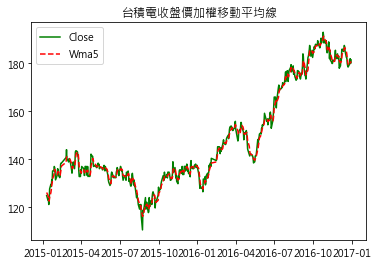

In [11]:
# 繪製加權移動平均線圖
plt.plot(Close[4:],label="Close",color='g')
plt.plot(Wma5[4:],label="Wma5",color='r',linestyle='dashed')
plt.title('台積電收盤價加權移動平均線')
plt.legend()

圖31.3：台積電5日加權移動平均線

#### 31.2.2 加權移動平均函數

用 Python 撰寫一個加權移動平均的函數 wmaCal()，以實現數據的加權移動平均。wmaCal() 函數定義程式碼如下：

In [12]:
def wmaCal(tsPrice,weight):
    k=len(weight)
    arrWeight=np.array(weight)
    Wma=pd.Series([np.nan]*len(tsPrice),index=tsPrice.index)
    for i in range(k-1,len(tsPrice.index)):
        Wma[i]=sum(arrWeight*tsPrice[(i-k+1):(i+1)])
    return(Wma)

用台積電股票的日收盤價數據來說明一下 wmaCal() 函數的使用方法。

In [13]:
# 計算台積電價格的加權移動平均值
wma5=wmaCal(Close,w)
wma5.head()

Date
2015-01-05        NaN
2015-01-06        NaN
2015-01-07        NaN
2015-01-08        NaN
2015-01-09    126.244
dtype: float64

In [14]:
wma5=wmaCal(Close,[0.1,0.15,0.2,0.25,0.3])
wma5.tail()

Date
2016-12-26    179.525
2016-12-27    179.425
2016-12-28    180.175
2016-12-29    180.275
2016-12-30    180.800
dtype: float64

加權移動平均值也可以用產生器來定義，具體函數如下：

In [15]:
def wmaCal_gene(price,w):
    priceList=[]
    n = len(price)
    w=np.array(w)
    k=len(w)
    for i in range(n):
        priceList.append(price[i])
        if len(priceList)==k:
            yield np.sum(np.array(priceList)*w)
            priceList.pop(0)

# 產生一個求加權移動平均值的產生器
wma5_generator=wmaCal_gene(Close,w)
next(wma5_generator)

126.244

### 31.3 指數加權移動平均

#### 31.3.1 指數加權移動平均數

實際上，指數加權移動平均數相當於一種特別的加權移動平均。仍以 5 日指數移動平均為例，給定一個權重值，比如 0.2。由加權移動平均的定義可知，前 4 期的 5 日加權移動平均數無法計算。假設第 5 期的 5 日加權移動平均數為 56.00，第 6 日的股票價格為 67.00，第 7 日的股價為 60.00。在計算第 6 期的加權移動平均數時，將第 5 期的加權移動平均數與第 6 期的股價作為加權的變數，將 0.8 和 0.2 作為二者的權重值，則第 6 期的加權移動均數為 $0.8\times56.00+0.2\times67.00=58.20$。運用同樣的方法，第 7 日的加權平均數為 $0.8\times58.20+0.2\times60.00=58.56$，用表格 31.1 展示如下.

>表 31.1：EWMA 計算表

日期|股價|權重|EWMA
:--:|:--:|:--:|:--:
5|     |0.2|56.00
6|67.00|0.2|0.8\*56.00+0.2\*67.00=58.20
7|60.00|0.2|0.8\*58.20+0.2\*0.00=58.56

將上述計算方法一般化，假設 $p_t$ 表示股票第 $t$ 期的價格，從第 $k$ 期開始計算股價的加權移動平均數，比如用前 $k$ 期的股價之簡單平均數求得，即

$$\mbox{EWMA}_{t=k}=\frac{p_1+p_2+...+p_k}{k}$$

從第 $k+1$ 期開始，每一期的移動平均數為當期股價與上一期移動平均數之加權平均，權重分別為 $\alpha$ 和 $1-\alpha$，即

$$\mbox{EWMA}_{t=k+1}=p_{k+1}\times\alpha+\mbox{EWMA}_{t=k}\times(1-\alpha)$$

第 $k+2$ 期指數加權移動平均數為：

$$
\begin{split}
\mbox{EWMA}_{t=k+2}&=p_{k+2}\times\alpha+\mbox{EWMA}_{t=k+1}\times(1+\alpha)\\
&=p_{k+2}\times\alpha+\left[p_{k+1}\times\alpha+\mbox{EWMA}_{t=k}\times(1+\alpha)\right]\times(1-\alpha)\\
&=p_{k+2}\times\alpha+p_{k+1}\times\alpha(1-\alpha)+\mbox{EWMA}_{t=k}\times(1-\alpha)^2
\end{split}
$$

依此類推，可以得出之後各期加權移動平均數。整體而言，當 $t\ge k+1$ 時，有

$$\mbox{EWMA}_{t}=\alpha\left[p_t+p_{t-1}\times(1-\alpha)+\cdots+p_{k+1}(1-\alpha)^{t-k-1}\right]+\mbox{EWMA}_{t=k}\times(1-\alpha)^{t-k}$$

其中 $\mbox{EWMA}_{t=k}=\dfrac{p_1+p_2+...+p_k}{k}$。在式子中，加權移動平均數是權重 $(1-\alpha)$ 的指數函數，因此這種計算移動平均數的方法被稱為指數加權移動平均。而且根據式子還可以看出，股價的指數加權移動平均數 $\mbox{EWMA}_{t}$，是過去所有期的價格 $(p_1,p_2,...,p_t)$ 之加權平均，從當期往過去價格之權重呈現指數遞減之現象。若將各期之指數加權移動平均數用折線圖繪製出來，就可得到股價的指數移動平均曲線。

接著以台積電股票為例，計算該股票收盤價的指數移動平均。再把指數移動平均用折線圖繪製出來，就可得到股價的指數移動平均曲線。

In [16]:
Ewma5=pd.Series([np.nan]*len(Close),index=Close.index)
Ewma5[4]=np.mean(Close[:4])
for i in range(5,len(Close)):
    Ewma5[i]=0.2*Close[i]+(1-0.2)*Ewma5[i-1]

Ewma5.tail()

Date
2016-12-26    181.236201
2016-12-27    180.988961
2016-12-28    181.191169
2016-12-29    180.952935
2016-12-30    181.062348
dtype: float64

Text(0.5, 1.0, '台積電收盤價指數加櫳移動平均線')

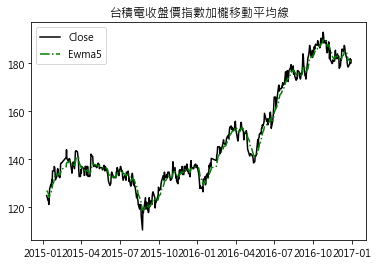

In [17]:
plt.plot(Close[4:],label="Close",color='k')
plt.plot(Ewma5[4:],label="Ewma5",\
        color='g',linestyle='-.')
plt.title("台積電收盤價指數加櫳移動平均線")
##plt.ylim(35,50)
plt.legend()

圖31.4：台積電5日指數移動平均線

#### 31.3.2 指數加權移動平均函數

用 Python 定義指數加權移動平均函數 ewmaCal()，函數定義及使用程式碼如下：

In [18]:
# 指數加權移動平均函數
def ewmaCal(tsprice,period=5,exponential=0.2):
    Ewma=pd.Series([np.nan]*len(tsprice),index=tsprice.index)
    Ewma[period-1]=np.mean(tsprice[:period])
    for i in range(period,len(tsprice)):
        Ewma[i]=exponential*tsprice[i]+(1-exponential)*Ewma[i-1]
    return(Ewma)

# 求台積電股價的指數加權移動平均數
Ewma=ewmaCal(Close,5,0.2)
Ewma.head(7)

Date
2015-01-05          NaN
2015-01-06          NaN
2015-01-07          NaN
2015-01-08          NaN
2015-01-09    126.64800
2015-01-12    125.93840
2015-01-13    125.46472
dtype: float64

In [19]:
Ewma.tail()

Date
2016-12-26    181.236201
2016-12-27    180.988961
2016-12-28    181.191169
2016-12-29    180.952935
2016-12-30    181.062348
dtype: float64

如果定義成產生器的形式，則可以採用下面的函數來實現。

In [20]:
def ewmaCal_gene(price,k,e):
    for i in range(k-1,len(price)):
        if i==k-1:
            ewmaValue=np.mean(price[:k])
        else:
            ewmaValue=e*price[i]+(1-e)*ewmaValue
        yield ewmaValue

# 產生一個計算指數加權移動平均數的產生器
ewma_generator=ewmaCal_gene(Close,5,0.2)
next(ewma_generator)

126.648

In [21]:
next(ewma_generator)

125.9384

### 31.4 建立 movingAverage 模組

介紹簡單移動平均、加權移動平均和指數加權移動平均的相關求法時，分別定義了求這三種均值的一些函數。為了以後方便呼叫這三種函數，可以把上面三種函數綜合在一個新的模組中。建立一個 .py 文件，並將文件命名為「movingAverage.py」，在該文件中輸入下面程式碼：

In [22]:
import pandas as pd
import numpy as np

def smaCal(tsPrice,k):
    sma=pd.Series([np.nan]*len(tsPrice),index=tsPrice.index)
    for i in range(k-1,len(tsPrice)):
        sma[i]=np.mean(tsPrice[(i-k+1):(i+1)])
    return(sma)

def smaCal_gene(price,k):
    # priceList只存需要計算的k期股價數據
    priceList=[]
    n = len(price)
    for i in range(n):
        # 在priceList中增加最新一筆數據
        priceList.append(price[i])
        if len(priceList)==k:
            yield np.mean(priceList)
            # 刪除priceList中第期數據
            priceList.pop(0)
def wmaCal(tsPrice,weight):
    k=len(weight)
    arrWeight=np.array(weight)
    Wma=pd.Series([np.nan]*len(tsPrice),index=tsPrice.index)
    for i in range(k-1,len(tsPrice.index)):
        Wma[i]=sum(arrWeight*tsPrice[(i-k+1):(i+1)])
    return(Wma)
def wmaCal_gene(price,w):
    # priceList只存需要計算的k期股價數據
    priceList=[]
    n = len(price)
    w=np.array(w)
    k=len(w)
    for i in range(n):
    # 在priceList中増加最新一筆數據
        priceList.append(price[i])
        if len(priceList)==k:
            yield np.sum(np.array(priceList)*w)
            # 刪除priceList中第0期數據
            priceList.pop(0)
def ewmaCal(tsprice,period=5,exponential=0.2):
    Ewma=pd.Series([np.nan]*len(tsprice),index=tsprice.index)
    Ewma[period-1]=np.mean(tsprice[:period])
    for i in range(period,len(tsprice)):
        Ewma[i]=exponential*tsprice[i]+(1-exponential)*Ewma[i-1]
    return(Ewma)
def ewmaCal_gene(price,k,e):
    for i in range(k-1,len(price)):
        if i==k-1:
            ewmaValue=np.mean(price[:k])
        else:
            ewmaValue=e*price[i]+(1-e)*ewmaValue
        yield ewmaValue

並將該文件保存到當前工作路徑下。透過滙入 movingAverage 模組來呼叫這些函數。若計算台積電收盤價的 10 日加權移動平均價，則可以透過下面程式碼實現：

In [23]:
##import movingAverage as ma
Ewma10=ma.ewmaCal(Close,10,0.2)
Ewma10.tail(n=3)

NameError: name 'ma' is not defined

### 31.5 常用平均方法的比較

以上幾種平均方法的區別主要體現在兩個方面：

1. 使用全域數據還是局部數據

   對於移動平均法（包括簡單移動平均和加權移動平均）所利用的數據都是局部的，即使用過去 $n$ 期的數據進行平均。而指數加權移動平均法，則使用的是全域（全部）數據。這種計算方式的差別，讀者再回顧一下兩種方法的公式，更能一目瞭然。

   簡單移動平均：$a_t=\dfrac{x_t+x_{t-1}+x_{t-2}+...+x_{t-n+1}}{n}$；
   
   加權移動平均法：$a_t=w_0x_t+w_1x_{t-1}+...+w_nx_{t-n+1}$；
   
   指數加權移動平均法：$a_t=\alpha x_t+\alpha(1-\alpha)x_{t-1}+\alpha(1-\alpha)^2x_{t-2}+...$。

2. 用同等權重還是差別權重。

   加權移動平均法和指數加權移動平均法，皆對不同時點的數據賦予不同的權重：對於較近的數據賦予較大的權重，而對於時間間隔較遠的數據則賦予較小的權重。因此，上述兩種方法更加重視對近期訊息的利用。雖然兩者都可以對近期數據賦予較大的權重，其權重的產生方法還是有差別的。在指數加權移動平均法中，各期權重隨時間間隔的增大而呈指數衰減。而加權移動平均法權重的確定則相對主觀一些，通常根據專家建議或者歷史經驗而確定。簡單移動平均法則對每一個數據都賦予相同的權重，即平均期數的倒數，簡單移動平均法對於每個時點的歷史數據採取相同的重視程度。

### 31.6 台積電股價數據與均線分析

瞭解完幾種均線的計算過程和求值方法以後，用 Python 撰寫程式碼繪製出台積電股票日度交易數據。

1. 提取出收盤價數據，並對收盤價進行總結分析。

In [ ]:
# 獲取台積電的股票數據
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import movingAverage as ma
TSMC=pd.read_csv('.\\PythonBook_code_data\\part5\\31\\2330.csv',sep='\t')
TSMC.index=pd.to_datetime(TSMC.Date)
Close=TSMC.Close
Close.describe()

2. 提取出台積電 2015 年的收盤價數據，以 10 天為時間跨度.計算台積電股價的 10 日簡單移動平均價 sma10、加權移動平均價 wma10 和指數移動平均價 ewma10。

In [ ]:
Close15=Close['2015']
# sma10
sma10=ma.smaCal(Close15,10)
sma10.tail(n=3)

# wma10
weight=np.array(range(1,11))/sum(range(1,11))
wma10=ma.wmaCal(Close15,weight)
wma10.tail(n=3)

# ewma10
expo= 2/(len(Close15)+1)
ewma10=ma.ewmaCal(Close15,10,expo)
ewma10.tail(n=3)

3. 繪製出台積電股價、簡單移動平均價、加權移動平均價和指數移動平均價的曲線圖，直觀展示均線走勢、波動情況和差異性。

In [ ]:
plt.plot(Close15[10:],label="Close",color='k')
plt.plot(sma10[10:],label="sma10",color='r',linestyle='dashed')
plt.plot(wma10[10:],label="wma10",color='b',linestyle=':')
plt.plot(ewma10[10:],label="ewma10",color='G',linestyle='-.')
plt.title('台積電股價和三種均線圖')
plt.legend()

圖 31.5：台積電股票收盤價的均線時序圖

從圖 31.5 可以看到，三條均線對原有的收盤價曲線都進行了一定程度的平均。就 10 日均線來說，簡單移動平均線、加權移動平均線走勢類似，而指數加權移動平均線由明顯的平滑效果，指數加權平均線較為平滑可能與選取的指數取值有關係。

### 31.7 均線時間跨度

無論是簡單移動平均線、加權移動平均線還是指數移動平均線，時間跨度的選擇都很為重要。股票數據可以為實時數據，也可以為以日為單位的數據。在時間跨度選擇上，可以選擇以分為單位，也可以選擇以日、周、月、季度甚至年為單位。以日單位，可以刻畫 5 日均線、10 日均線、20 日均線、25 日均線；以周為單位，5 周均線、10 周均線；以月為單位，可以有 3 個月均線、12 個月均線、24 個月均線等。均線的時間跨度選擇根據實際要分析的問題來確定。不同時間跨度的均線對於價格趨勢的刻畫和敏感度會有差別。均線一般分為短期均線和長期均線，但所謂的短期和長期並沒有明確的區分界限。與 18 個月的均線相比，20 日均線可以看做短期均線。如果只在 5 日均線和 20 日均線中區分短期均線和長期均線，我們往往會把 5 日均線叫做短期均線，20 日均線稱作長期均線。

定義 5 日簡單移動平均線為短期均線，30 日簡單移動平均線為長期均線，然後運用台積電 2015 年的價格數據，畫出台積電 2015 年收盤價的短期均線與長期均線。

In [ ]:
sma5=ma.smaCal(Close15,5)
sma30=ma.smaCal(Close15,30)
plt.plot(Close15[30:],label="Close",color='k')
plt.plot(sma5[30:],label="sma5",color='b',linestyle='dashed')
plt.plot(sma30[30:],label="sma30",color='k',linestyle=':')
plt.title("台積電股票價格的長短期均線")
plt.legend()

圖 31.6：台積電收盤價的短期與長期均線圖

從台積電收盤價的短期與長期均線圖中發現，Sma5 線對收盤價進行簡單平均，刻畫出收盤價的周趨勢，5 日簡單移動平均線對收盤價線較為敏感，Sma5 和收盤價線的上下走勢基本上一致。而 Sma30 較為平均，刻畫的是收盤價的月度趨勢。與 Sma5相比，Sma30 對於收盤價的敏感性比較小，波動率也較小。Sma5 線相對於價格線有壓力與支撐的意義；當價格線向下突破 Sma5 線時，價格短期處於向下趨勢。當價格線向上突破 Sma5 線時，價格短期處於上升趨勢。如果價格線向下沒有突破 Sma5 線，則價格未來可能有上漲的趨勢。

### 31.8 台積電股票均線系統交易

均線系統策略的直覺是短、長期趨勢的消長，不同的消長變化對交易有不同的指導意義，在下文分別示範一些簡單的例子。

#### 31.8.1 簡單移動平均線制定台積電股票的買賣點

價格的移動平均線可以解讀為價格的壓力線和支撐線。一般而言，當股票處於上漲行情中，若均線處於價格線的上方，均線起到壓力線的作用。如果價格曲線向上穿過壓力線，則表明價格有較強的上漲趨勢，這個穿越釋放出買入信號。反之，在下跌行情中，在價格線的下方的均線起到支撐的作用。如果價格線向下穿越均線，說明價格下跌趨勢較強烈，則釋放出賣出信號。

**Example.**
根據價格線與 10 日簡單移動平均線來尋找台積電股票 2015 年到 2016 年的買賣點。

In [ ]:
# 產生一個日簡單移動均線的產生器
sma10_gene=ma.smaCal_gene(Close,10)
sma10_before = next(sma10_gene)
smaSignal=[]
for i in range(11,len(Close)):
    sma10_now = next(sma10_gene)
    # 股價上穿均線，signal為1
    if Close[i-1]<sma10_before and Close[i]>sma10_now:
        smaSignal.append(1)
    # 股價下穿均線，signal為-1
    elif Close[i-1]>sma10_before and Close[i]<sma10_now:
        smaSignal.append(-1)
    else:
        smaSignal.append(0)
    sma10_before = sma10_now

smaSignal = pd.Series(smaSignal,index=Close.index[11:])

運用 Python 來捕捉價格線從下向上穿 10 日均線和從上下穿 10 日均線的日期，價格線向上突破 10 日均線時，釋放出買入信號；當向下突破 10 日均線時，釋放出賣出信號。具體執行買賣交易的時點設為買賣信號出現後的第 2 期，然後評價此交易策略的好壞。

In [ ]:
smaTrade=smaSignal.shift(1).dropna()
smaBuy=smaTrade[smaTrade==1]
smaBuy.head(n=3)

smaSell=smaTrade[smaTrade==-1]
smaSell.head(n=3)

# 計算單期日收益率
tsmcRet=Close/Close.shift(1)-1
smaRet=(tsmcRet*smaTrade).dropna()
# 累積收益率表現
cumStock=np.cumprod(1+tsmcRet[smaRet.index[0]:])-1
cumTrade=np.cumprod(1+smaRet)-1
cumdata=pd.DataFrame({'cumTrade':cumTrade,\
                    'cumStock':cumStock})
cumdata.iloc[-6:,:]

# 繪製累積收益率圖
plt.plot(cumStock,label="cumStock",color='k')
plt.plot(cumTrade,label="cumTrade",color='r',linestyle=':')
plt.title('股票本身與均線交易的累積收益率')
plt.legend()

圖 31.7：簡單均線交易績效表現

從圖 31.7 中，可以看出簡單均線交易策略表現很差。接下來，計算 10 日簡單均線交易策略買賣點預測的準確率。

In [ ]:
# 求買賣點預測準確率
smaRet[smaRet==(-0)]=0
smaWinrate=len(smaRet[smaRet>0])/len(smaRet[smaRet!=0])
smaWinrate

從準確率結果看出，單純的 10 日簡單均線策略這個指標不適於台積電 2015 年和 2016 年的股票走勢預測。

#### 31.8.2 雙均線交叉捕捉台積電股票的買賣點

雙均線交叉策略的思想，是利用長短期均線的相對關係，來識別價格趨勢的變化。其策略制定過程有三個步驟。

1. 先求出短期均線和長期均線；

2. 當短期均線從下向上穿過長期均線時，釋放出買入信號；

3. 當短期均線從上向下穿過長期均線時，釋放出賣出信號。

再次提醒讀者，短期和長期的時間跨度是因人而異的。

**Example.**
選擇 5 日簡單移動平均線為短期線，30 日簡單移動平均線為長期線。運用長短期均線交叉策略的思想，用 Python 捕捉長短期均線突破點，並且制定台積電股票 2015 年 1 月到 2016 年 12 月份的買賣交易點。

In [ ]:
# 分別產生5日sma產生器和30日sma產生器
sma5_gene=ma.smaCal_gene(Close,5)
sma30_gene=ma.smaCal_gene(Close,30)

接下來，尋找買賣交易信號並制定交易執行日期。

In [ ]:
sma5_before = next(sma5_gene)
sma30_before = next(sma30_gene)
SLSignal=[]
for i in range(31,len(Close)):
    sma5_now = next(sma5_gene)
    sma30_now = next(sma30_gene)
    if sma5_before<sma30_before and sma5_now>sma30_now:
        SLSignal.append(1)
    elif sma5_before>sma30_before and sma5_now<sma30_now:
        SLSignal.append(-1)
    else:
        SLSignal.append(0)
    sma5_before = sma5_now
    sma30_before = sma30_now

SLSignal = pd.Series(SLSignal,index = Close.index[31:])
SLSignal[SLSignal==1]

SLSignal[SLSignal==-1]

SLTrade=SLSignal.shift(1)
# 計算股價上升的預測準確率
Long=pd.Series(0,index=SLTrade.index)
Long[SLTrade==1]=1
LongRet=(Long*tsmcRet).dropna()
winLrate=len(LongRet[LongRet>0])/len(LongRet[LongRet!=0])
winLrate

# 從winLrate的值為0.3可以看出，
# 雙均線交叉對股價上升的預測準確率為0.3。
# 計算股價下跌的預測準確率
Short= pd.Series(0,index=SLTrade.index)
Short[SLTrade==-1]=-1
ShortRet=(Short*tsmcRet).dropna()
winSrate=len(ShortRet[ShortRet>0])/len(ShortRet[ShortRet!=0])
winSrate

# 雙均線交叉對股價下趺的預測準確率為0.89
# 計算股價變化趨勢的預測獲勝率
SLtradeRet=(SLTrade*tsmcRet).dropna()
winRate= len(SLtradeRet[SLtradeRet>0])/len(SLtradeRet[SLtradeRet]!=0)
winRate

根據上述雙均線交易策略發現的買賣點日期，制定三種交易策略，即只進行做多交易、只進行做空交易和做多做空兩者都可的交易，對比分析這三種交易策略的績效表現，結果如圖 31.8 所示。

In [ ]:
cumLong=np.cumprod(1+LongRet)-1
cumShort=np.cumprod(1+ShortRet)-1
cumSLtrade=np.cumprod(1+SLtradeRet)-1
plt.plot(cumSLtrade,label="cumLong&Short",color='k')
plt.plot(cumLong,label="cumLong",\
        color='b',linestyle='dashed')
plt.plot(cumShort,label="cumShort",\
        color='r',linestyle=':')
plt.title('長短期均線交易累積收益率')
plt.legend(loc='best')

圖 31.8：長短期均線交易耫效表現

### 31.9 異同移動平均線（MACD）

異同均線（Moving Average Convergence / Divergence）是由指數均線演變過來，由 Gerald Appel 在二十世紀七十年代提出，是股票分析中一種常見的指標。MACD 指標是由兩線一柱組合起來形成，快速線為 DIF，慢速線為 DEA，柱狀圖為 MACD。快速線 DIF 一般由 12 日指數加權移動平均值減掉 26 日指數加權移動平均值得到，慢速線 DEA 是 DIF 的 9 日指數加權移動平均值。柱狀圖 MACD 由快速線 DIF 與慢速線 DEA 作差得到。MACD 指標可以反映出股票近期價格走勢的能量和變化強度，透過分析快慢速線和柱狀圖來把握股票的買入和賣出點。一般默認 MACD 的求值參數為 12、26 和 9，在投資實戰中，可以對這些參數進行優化。

#### 31.9.1 MACD 的求值過程

計算離差值 DIF，DIF 的計算方式，為 12 日指數移動平均值 $\mbox{EMA}_{(close,12)}$ 減去 26 日指數移動平均值 $\mbox{EMA}_{(close,26)}$，數學公式表達為：

$$\mbox{DIF}=\mbox{EMA}_{(close,12)}-\mbox{EMA}_{(close,26)}$$

以台積電股票交易數據為例，用前面定義的 ewmaCal() 函數來計算離差值 DIF。

In [ ]:
DIF=ma.ewmaCal(Close,12,2/(1+12))\
       -ma.ewmaCal(Close,26,2/(1+26))
DIF.tail(n=3)

計算 DEA 的值；

求出離差值 DIF 以後，一般選取 9 日為時間跨度，求離差值 DIF 的 9 日指數移動平均值 $\mbox{EMA}_{(\mathit{DIF},9)}$，這個平均值也就是 MACD 的衡量指標。用 DEA 或者 DEF 來表示這一均值，即

$$\mbox{DEA}=\mbox{EMA}_{(\mathit{DIF},9)}$$

另外，由 DEA 畫出來的線也被稱作信號線。

In [ ]:
DEA=ma.ewmaCal(DIF.dropna(),9,2/(1+9))
DEA.tail()

計算 MACD 的值

$$\mbox{MACD}=\mbox{DIF}-\mbox{DEA}$$

In [ ]:
MACD=DIF-DEA
MACD.tail(n=3)

繪製 2016 年 12 月份的兩條信號線 DIF 和 DEA 與一個柱狀圖 MACD。

In [ ]:
plt.subplot(211)
plt.plot(DIF['2016-12'],label="DIF",color='k')
plt.plot(DEA['2016-12'],label="DEA",color='b',linestyle='dashed')
plt.title('信號線DIF與DEA')
plt.legend()
plt.subplot(212)
plt.bar(MACD['2016-12'].index,\
#plt.bar(left=MACD['2016-12'].index,\
        height=MACD['2016-12'],\
        label='MACD',color='r')
plt.title('柱狀圖MACD')
plt.legend()

圖 31.9：信號線DIF、DEA與柱狀圖MACD

#### 31.9.2 異同均線（MACD）捕捉台積電股票的買賣點

MACD 是投資實戰中被投資者廣泛使用的指標，由雙移動平均線發展變化而來，再引入一個新的指標（DIF）來刻畫短期和長期移動平均線的聚合與差離，並對雙均線的差離再次平均，得到一條信號線（DEA）。

In [ ]:
macddata=pd.DataFrame()
macddata['DIF']=DIF['2016-08':'2016-12']
macddata['DEA']=DEA['2016-08':'2016-12']
macddata['MACD']=MACD['2016-08':'2016-12']
macddata.head()

In [ ]:
macddata.tail()

接下來，綜合分析蠟燭圖和 MACD 圖，將蠟燭圖和 MACD 圖繪製在同一個圖片中。在前面的分析中，我們有介紹過 candleLinePlots() 函數，此函數可以繪製上下兩張圖，下面那個圖形框中可以繪製一條或者兩條直線。根據當前的需求，caneLinePlots() 函數除了繪製線圖以外，也要能夠繪製 MACD 的柱狀圖。此處，在 candleLinePlots() 函數原有的定義下増加一些新的判斷條件，使得其可以繪製柱狀圖。

In [ ]:
# 蠟燭圖與線圖，柱狀圖
def candleLinePlots(candleData, candleTitle='a', **kwargs):
    Date = [date2num(date) for date in candleData.index]
    candleData.loc[:,'Date'] = Date
    listData = []
    for i in range(len(candleData)):
        a = [candleData.Date[i],\
            candleData.Open[i],candleData.High[i],\
            candleData.Low[i],candleData.Close[i]]
    listData.append(a)
    # 如果不定長參數無取值，只畫蠟燭圖
    ax = plt.subplot()
    # 如果不定長參數有值，則分成兩個子圖
    flag=0
    if kwargs:
        if kwargs['splitFigures']:
            ax = plt.subplot(211)
            ax2= plt.subplot(212)
            flag=1;
        # 如果無參數 splitFigures，則只畫一個圖形框
        # 如果有參數 splitFigures，則畫出兩個圖形框
        for key in kwargs:
            if key=='title':
                ax2.set_title(kwargs[key])
            if key=='ylabel':
                ax2.set_ylabel(kwargs[key])
            if key=='grid':
                ax2.grid(kwargs[key])
            if key=='Data':
                plt.sca(ax)
                if flag:
                    plt.sca(ax2)
                # 一維數據
                if kwargs[key].ndim==1:
                    plt.plot(kwargs[key],\
                             color='k',\
                             label=kwargs[key].name)
                    plt.legend(loc='best')
                # 二維數據有兩個columns
                elif all([kwargs[key].ndim==2,\
                          len(kwargs[key].columns)==2]):
                    plt.plot(kwargs[key].iloc[:,0], color='k',\
                             label=kwargs[key].iloc[:,0].name)
                    plt.plot(kwargs[key].iloc[:,1],\
                             linestyle='dashed',\
                             label=kwargs[key].iloc[:,1].name)
                    plt.legend(loc='best')
                # 二維數據有3個columns
                elif all([kwargs[key].ndim==2,\
                          len(kwargs[key].columns)==3]):
                    plt.plot(kwargs[key].iloc[:,0], color='k',\
                             label=kwargs[key].iloc[:,0].name)
                    plt.plot(kwargs[key].iloc[:,1],\
                             linestyle='dashed',\
                             label=kwargs[key].iloc[:,1].name)
                    plt.bar(kwargs[key].iloc[:,2].index,\
                    #plt.bar(left = kwargs[key].iloc[:,2].index,\
                             height = kwargs[key].iloc[:,2],\
                             color = 'r',\
                             label=kwargs[key].iloc[:,2].name)
                    plt.legend(loc='best')
    mondays = WeekdayLocator(MONDAY)
    weekFormatter = DateFormatter('%y %b %d')
    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_minor_locator(DayLocator())
    ax.xaxis.set_major_formatter(weekFormatter)
    plt.sca(ax)
    candlestick_ohlc(ax.listData, width=0.7,\
                     colorup='r',colordown='g')
    ax.set_title(candleTitle)
    plt.setp(ax.get_xticklabels(),\
             rotation=20,\
             horizontalalignment='center')
    ax.autoscale_view()
    return(plt.show())

然後，呼叫此函數來繪製台積電 2016 年 8 月到 12 月份的日 K 線圖與 MACD 圖。

In [ ]:
##from matplotlib.dates import DateFormatter, WeekdayLocator,\
##                                DayLocator, MONDAY, date2num
import candle
candle.candleLinePlots(TSMC['2016-08':'2016-12'],\
            candleTitle='台積電2016年8月到12月份的日Ｋ線圖',\
            splitFigures=True,Data=macddata,\
            ylabel='MACD')

圖 31.10：台積電股票2016年8月到12月的Ｋ線圖與MACD

我們闡述一些常用的 MACD 交易思想。圖 31.10 下方 MACD 圖中實線表示 DIF，虛線表示 DEA 信號線。

1. 當 DIF 和 DEA 都在零刻度線上方時，表明市場可能多頭行情；反之，DIF 和 DEA 都在零刻度下方時，表明市場可能處於空頭行情。在投資實戰中，「零上雙金叉亅策略廣為人們使用。DIF 和 DEA 都在零刻度線上方，在一段時間內，DIF 先上穿 DEA 線，不久 DIF 下跌到 DEA 線的下方，然後 DIF 又上穿 DEA 線，此時，說明股票價格上升趨勢較強，市場處於上漲行情中。

2. 當 DIF 下穿信號線 DEA 時，釋放出買入信號；當 DIF 上穿過信號線 DEA 時，釋放出賣出信號。台積電 2016 在 9 月 19 日附近，兩條線都呈現上升趨勢，DIF 從下向上穿越 DEA，釋放出市場慢慢走強的信號。觀察Ｋ線圖可知，從 9 月 19 日以後，市場大體上處於上升行情中。2016 在 10 月 20 日附近，兩條線都呈現下降趨勢，DIF 下穿 DEA，同時觀察Ｋ線圖可知，從 10 月 20 日以後，市場大體轉為下跌行情。

3. MACD 中的柱形圖表示 DIF 與 DEA 的差值。柱形圖的高低表 DIF 與 DEA 差值的大小。柱形圖在零刻度附近時，釋放出買賣信號。柱形圖在零刻度線上方，表示 DIF 大於 DEA，巿場走勢較強；柱形圖在零刻度下方，表示 DIF 小於 DEA，市場走勢較弱。

4. 在投資實戰中，柱形圖的型態也是投資者關注的一大焦點，MACD 指標的型態分析方法可以套用一般的型態分析理論與方法。MACD 柱形圖高低的變化，與價格線走勢的背離情況也可以被解讀為交易信號。

在一般技術分析中，MACD 指標的分析方式不可悉數，優化 MACD 的參數也可以衍生出更多的分析方式。以 DIF 與 DEA 線的交叉與背離為例，用 Python 刻畫這一策略的情景並自動捕捉買賣點。

DIF 與 DEA 線的交叉與背離這一策略的分析過程包括如下 3 個步驟。

1. 先求出 DIF（差離值，快線）、DEA（信號線，慢線）的值；

2. DIF、DEA 均為正，DIF 向上突破 DEA，買入信號；

3. DIF、DEA 均為負，DIF 向下跌破 DEA，賣出信號。

In [ ]:
DEA=DEA.dropna()
DIF=DIF[DEA.index]
macdSignal=pd.Series(0,index=DIF.index)
for i in range(1,len(DIF)):
    if all([DIF[i]>DEA[i]>0.0,DIF[i-1]<DEA[i-1]]):
        macdSignal[i]=1
    elif all([DIF[i]<DEA[i]<0.0,DIF[i-1]>DEA[i-1]]):
        macdSignal[i]=-1

macdSignal.tail()

In [ ]:
macdTrade=macdSignal.shift(1)
macdRet=(tsmcRet*macdTrade).dropna()
macdRet[macdRet==-0]=0
macdWinRate=len(macdRet[macdRet>0])/len(macdRet[macdRet!=0])
macdWinRate

### 31.10 多種均線指標綜合運用模擬實測

透過前面小節的敘述可知，簡單移動平均線、雙均線交叉和異同移動平均線均可用於捕捉買賣點。現在將這三個交易策略綜合在一起，共同捕捉買賣點。嘗試運用多種指標捕捉買賣點，一方面可以捕捉到更多的買賣點[<sup>2</sup>](#fn2)；另一方面，在買賣點信號方面，不同指標釋放的交易信號甚至可能會相反。比如，簡單移動平均線釋在某一交易日期放出買入信號，而雙均線交叉策略在當期釋放出賣出信號。多種指標分析有助於我們多方面研判市場行情，交易決策的制定會更加謹慎，進而有可能提高交易策略的獲勝率。

在實際交易時，我們會有交易資金，購買股票的份額等方面的考慮。在綜合運用多種均線指標制定交易策略時，除了捕捉買賣點以外，還可以把交易資金、購買股票的份額等實際因素考慮進去。在底下交易策略的制定上，我們考慮下面三大的問題：

1. 計算指標，制定買賣交易信號。

2. 設定初始資金，有交易信號時，進行買賣交易。

3. 投資交易的回測與評價。

接下來，計算三種均線指標、刻畫交易思想、捕捉買賣點信號並實踐交易模型。

首先，將上述三種策略捕捉的買賣點信號綜合在一起，計算新的買賣交易信號；

In [ ]:
# 合併交易信號
AllSignal=smaSignal+SLSignal+macdSignal
for i in AllSignal.index:
    if AllSignal[i]>1:
        AllSignal[i]=1
    elif AllSignal[i]<-1:
        AllSignal[i]=-1
    else:
        AllSignal[i]=0

<span id="fn2"><sup>2</sup> 注意，不同指標捕捉的買賣點信號不一定一致；而有信號也不代表我們可以不假思索就據以買賣。</span>

In [ ]:
AllSignal[AllSignal==1]

In [ ]:
AllSignal[AllSignal==-1]

In [ ]:
tradSig=AllSignal.shift(1).dropna()

設定初始資產 1000000 元，根據買賣點訊號，進行台積電模擬交易。

In [ ]:
Close=Close[-len(tradSig):]
cash=pd.Series(0.0,index=Close.index)
share=pd.Series(0,index=Close.index)
# 當價格連續兩天上升且交易信號沒有顯示賣出時，
# 第一次開賬戶持有股票
entry=3
cash[:entry]=1000000
while entry<len(Close):
    cash[entry]=cash[entry-1]
    if all([Close[entry-1]>=Close[entry-2],\
            Close[entry-2]>=Close[entry-3],\
            AllSignal[entry-1]!=-1]):
        share[entry]=1000
        cash[entry]= cash[entry]-1000*Close[entry]
        break
    entry+=1

# 進場以後，根據交易信號交易股票
i=entry+1
while i<len(tradSig):
    cash[i]=cash[i-1]
    share[i]=share[i-1]
    if tradSig[i]==1:
    # 買入時，買入3000share
        share[i] = share[i]+3000
        cash[i] = cash[i]-3000*Close[i]
    # 賣出時、賣出1000share
    elif tradSig[i]==-1:
        share[i] = share[i]-1000
        cash[i] = cash[i]+1000*Close[i]
    i+=1

asset=cash+share*Close
asset.tail()

最後，對我們的交易進行一些評價，繪製交易賬戶的曲線圖並計算總資產收益率。

In [ ]:
# 繪製交易賬戶曲線圖
plt.subplot(411)
plt.title('2015-2016年上：台積電均線交易賬戶')
plt.plot(Close, color='b')
plt.ylabel("Price")
plt.subplot(412)
plt.plot(share, color='b')
plt.ylabel("Share")
plt.ylim(0,max(share)+1000)
plt.subplot(413)
plt.plot(asset,label="asset",color='r')
plt.ylabel("Asset")
plt.ylim(min(asset)-500,max(asset)+5000)
plt.subplot(414)
plt.plot(cash,label="cash",color='g')
plt.ylabel("Cash")
plt.ylim(min(cash)-5000,max(cash)+5000)
# 計算資產收益率率（不考慮交易成本）
TradeReturn=(asset[-1]-1000000)/1000000
TradeReturn

從程式碼中可以看出，在不考慮交易成本的情況下，該交易策略的資產收益率為 14.15%。

圖 31.11：2015-2016年台積電交易賬戶的時序圖